# **Predicting Uber Ride Completion**


#Objective

###The objective is to analyse Uber ride data to identify patterns that affect ride completion and cancellations. Build predictive models to classify whether a ride will be completed, cancelled, or left incomplete. Generate insights to help Uber reduce cancellations, improve driver performance, and enhance customer satisfaction.

#Problem Statement



###“How can we analyze Uber ride data to identify key factors affecting ride completion, cancellations, and customer satisfaction, and predict whether a ride will be completed successfully?”




#**Stage** 1:

##**Dataset Selection**

#Source / Timeline / Location
###Kaggle / 2024 / India

#Types of Problem
###Classification

#Possible Algorithm Planned to use


###Logistic Regression
###Decision Tree Classifier
###Random Forest Classifier
###Gradient Boosting (XGBoost / LightGBM / CatBoost)
###K-Nearest Neighbors (KNN)
###Support Vector Machine (SVM)

#**Dataset Description**


#**Key Features**

###Booking ID – Unique identifier for each ride.

###Date / Time – When the booking was made.

###Customer ID – Unique identifier of the customer.

###Driver ID – Unique identifier of the driver.

###Vehicle Type – Car type (Mini, Sedan, SUV, etc.).

###Pickup Location – Origin of the trip.

###Drop Location – Destination of the trip.

###Ride Distance (km) – Distance traveled.

###Ride Duration (minutes) – Time taken for the trip.

###Booking Value (Fare Amount) – Total cost of the ride.

###Booking Status – Completed, Cancelled by Customer, Cancelled by Driver, or Incomplete.

###Avg Customer Rating – Rating given by the customer.

###Avg Driver Rating – Rating given to the driver.

###Waiting Time (VTAT / CTAT) – Time taken for driver arrival or customer waiting.  






#Sample Outcome
###**Target Feature:** Booking Status (Completed, Cancelled by Customer, Cancelled by Driver, Incomplete)

###**Input Features**: Ride Distance,Waiting Time (VTAT, CTAT),Driver Rating,Vehicle Type,Customer Rating,Pickup Location,Pickup Location,Drop Location,Time of Day / Date,Booking Value (Fare Amount)


#**Sample Output**

###The model correctly classified 85% of rides as Completed or Cancelled.
##It identified waiting time, ride distance, and driver ratings as the strongest predictors.
###The results provide actionable insights for Uber to reduce cancellations and improve service quality.

#Initial EDA
###Read the data from Github - raw link

###Info

###Describe

###Null Values

###duplicates

In [1]:
%pip install xgboost lightgbm --quiet

In [2]:
import os
import io
import zipfile
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, auc)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
df = pd.read_csv('https://github.com/Manigandan-1306M-Analyst/csv/raw/refs/heads/main/Data_Analytics.zip')
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


In [4]:
#Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

In [5]:
#summary of descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg VTAT,139500.0,8.456352,3.773564,2.0,5.30,8.30,11.30,20.0
Avg CTAT,102000.0,29.149636,8.902577,10.0,21.60,28.80,36.80,45.0
Cancelled Rides by Customer,10500.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.0
Cancelled Rides by Driver,27000.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.0
Incomplete Rides,9000.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.0
Booking Value,102000.0,508.295912,395.805774,50.0,234.00,414.00,689.00,4277.0
Ride Distance,102000.0,24.637012,14.002138,1.0,12.46,23.72,36.82,50.0
Driver Ratings,93000.0,4.230992,0.436871,3.0,4.10,4.30,4.60,5.0
Customer Rating,93000.0,4.404584,0.437819,3.0,4.20,4.50,4.80,5.0


In [6]:
missing = df.isnull().sum().sort_values(ascending=False)
miss_pct = (missing / len(df) * 100).round(2)
missing_df = pd.concat([missing, miss_pct], axis=1)
missing_df.columns = ['missing_count', 'missing_pct']
print(missing_df[missing_df['missing_count']>0].head(30))

                                   missing_count  missing_pct
Incomplete Rides Reason                   141000         94.0
Incomplete Rides                          141000         94.0
Reason for cancelling by Customer         139500         93.0
Cancelled Rides by Customer               139500         93.0
Cancelled Rides by Driver                 123000         82.0
Driver Cancellation Reason                123000         82.0
Driver Ratings                             57000         38.0
Customer Rating                            57000         38.0
Avg CTAT                                   48000         32.0
Ride Distance                              48000         32.0
Booking Value                              48000         32.0
Payment Method                             48000         32.0
Avg VTAT                                   10500          7.0


In [7]:
#DataSet shape
df.shape

(150000, 21)

In [8]:
df.duplicated().sum()

np.int64(0)

##Target Variable Detection

In [9]:
TARGET_COL = None
for col in df.columns:
    if "status" in col.lower() or "completed" in col.lower():
        TARGET_COL = col
        break

print("Detected target column:", TARGET_COL)

Detected target column: Booking Status


In [10]:
# Convert target to binary
if df[TARGET_COL].dtype == 'O':
    df['target'] = df[TARGET_COL].apply(lambda x: 1 if str(x).lower() in ["completed", "done", "success"] else 0)
else:
    df['target'] = df[TARGET_COL]

print(df['target'].value_counts())

target
1    93000
0    57000
Name: count, dtype: int64


##Visualize Target

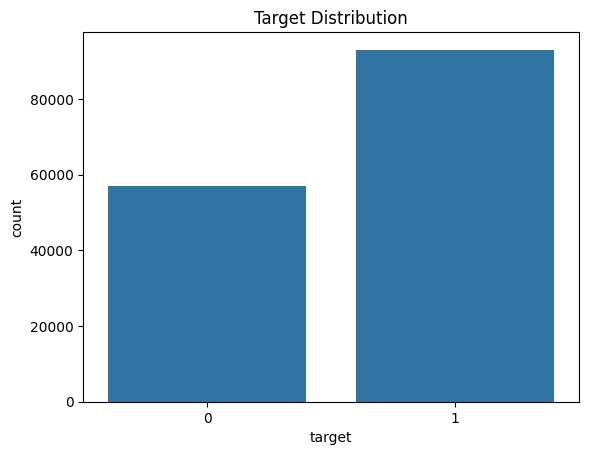

In [11]:
sns.countplot(x='target', data=df)
plt.title("Target Distribution")
plt.show()

#Interpretation of Visualize Target
1.  "Visualize Target" is the process of creating a visual representation of the outcome the model is trying to predict.
2.  This step helps to understand the distribution of different ride statuses (e.g., Completed vs. Cancelled).
3.  The main goal is to identify **class imbalance**, which is when one status occurs much more frequently than others.

##Visualize Numerical Columns (Boxplots in groups of 10)

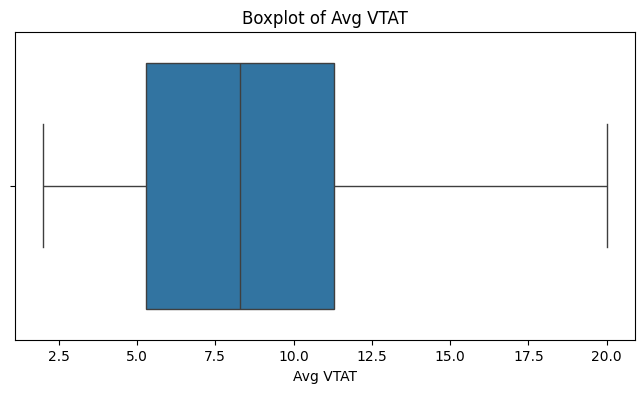

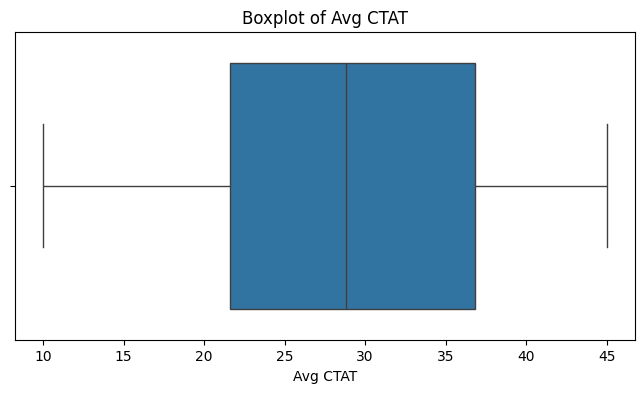

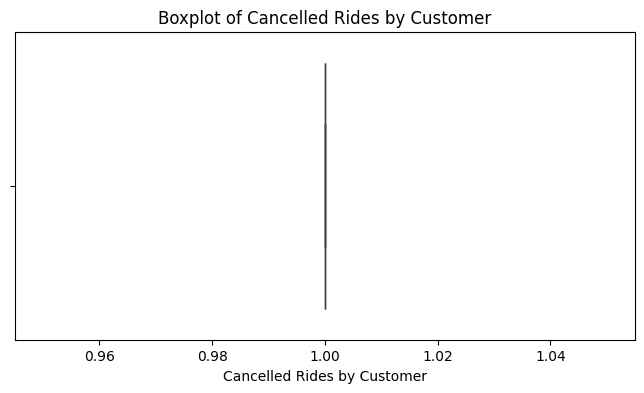

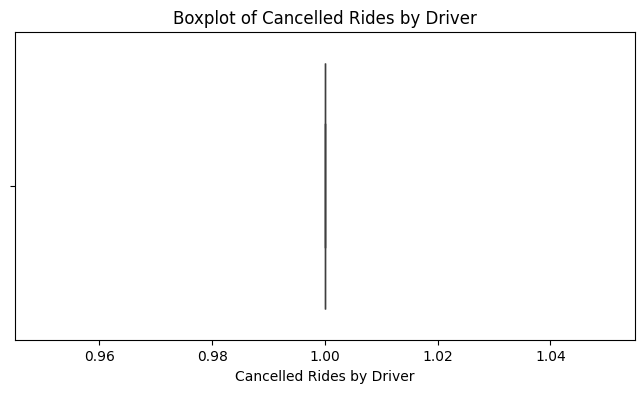

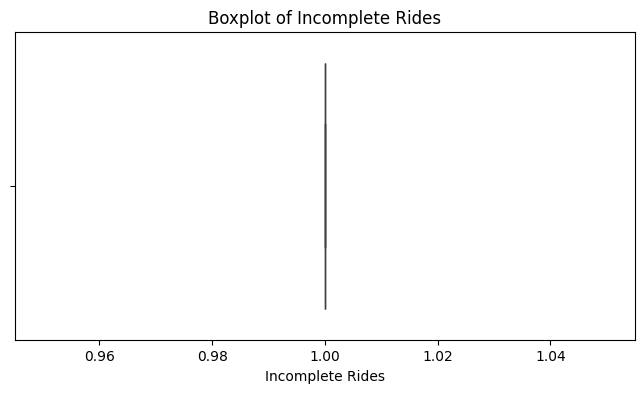

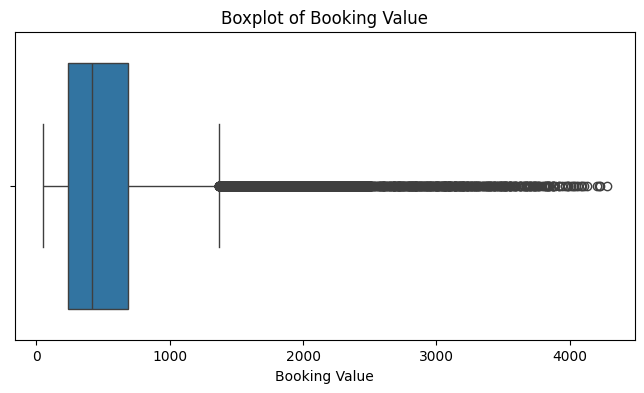

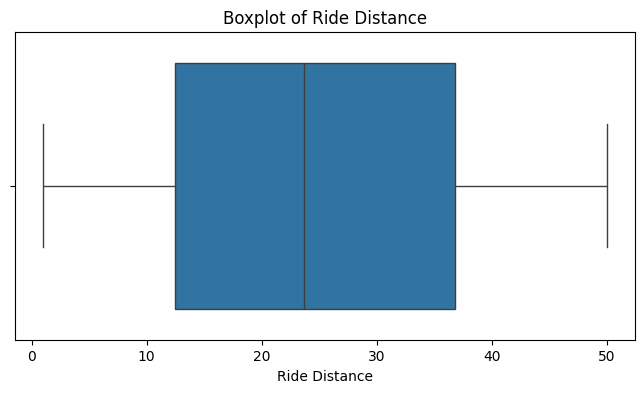

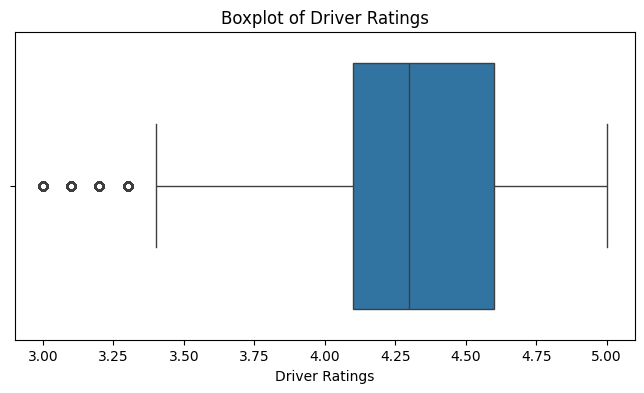

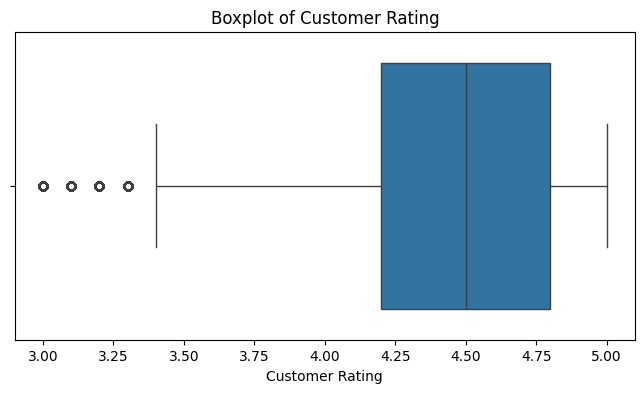

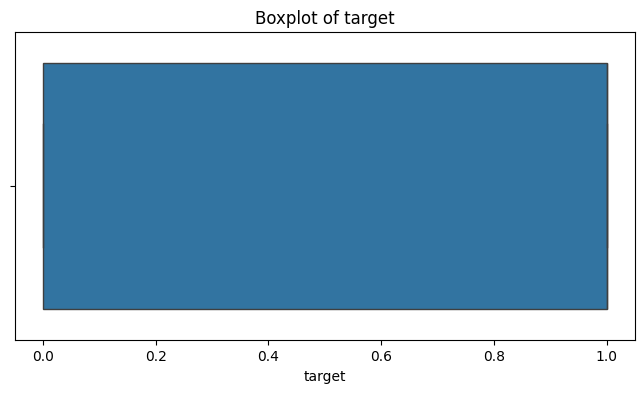

In [12]:
num_cols = df.select_dtypes(include=['number']).columns

for i in range(0, len(num_cols), 10):
    subset = num_cols[i:i+10]
    for col in subset:
        plt.figure(figsize=(8,4))
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
        plt.show()

#Interpretation for Visualize Numerical Columns (Boxplots in groups of 10)
* This process uses **boxplots** to visually represent the key statistical summaries of numerical data, such as ride duration or distance.
* The boxplot shows the **median** (middle value), **quartiles** (the 25th and 75th percentiles), and potential **outliers** (data points that are significantly different from others).
* The phrase **"in groups of 10"** is a practical method for managing a large number of numerical features. Instead of creating one crowded plot, the columns are grouped to make the visualization easier to read and analyze, allowing for a focused inspection of each set of features.

##Visualize Numerical Columns (Histograms in groups of 10)

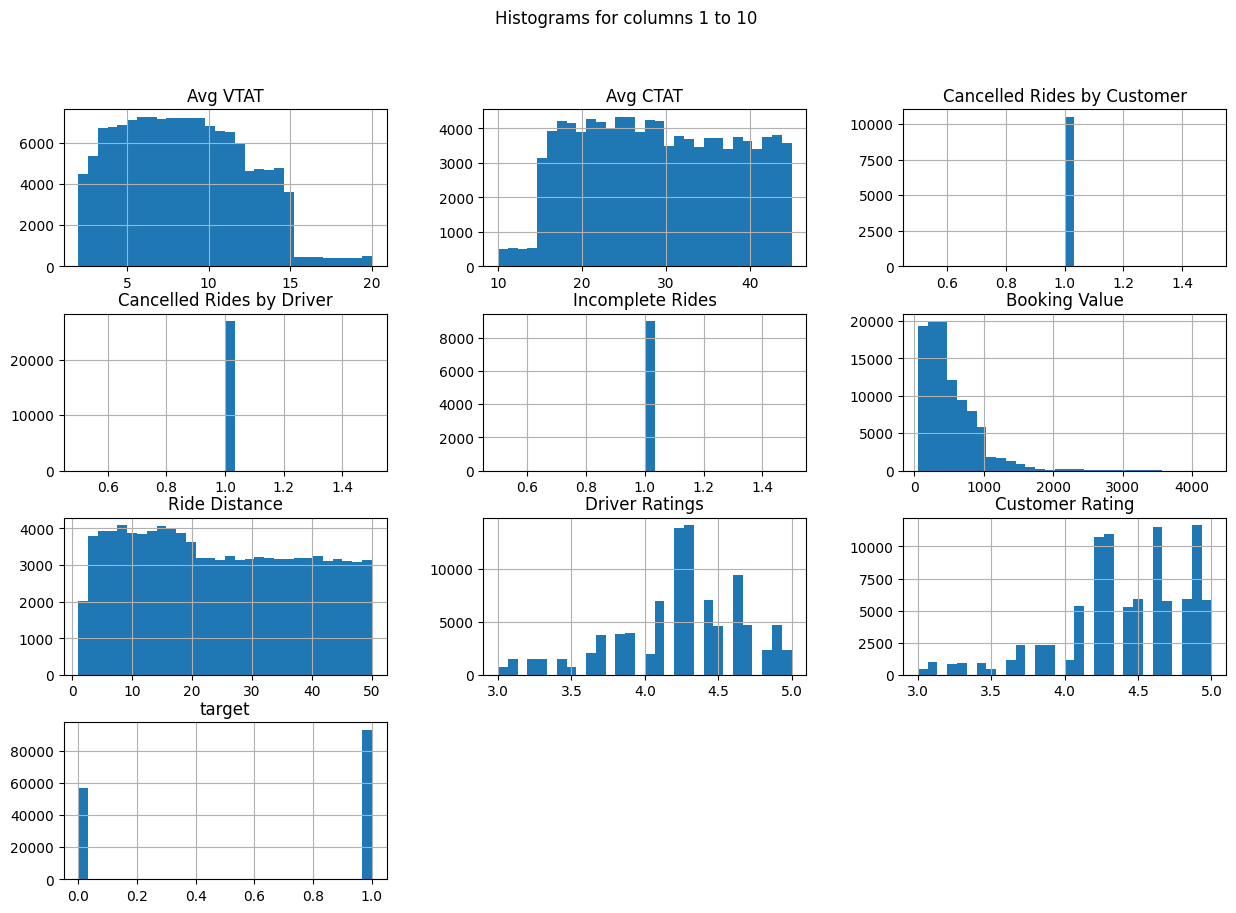

In [13]:
for i in range(0, len(num_cols), 10):
    subset = num_cols[i:i+10]
    df[subset].hist(figsize=(15,10), bins=30)
    plt.suptitle(f"Histograms for columns {i+1} to {i+len(subset)}")
    plt.show()

#Interpretation for Visualize Numerical Columns (Histograms in groups of 10)

* A **histogram** is a type of bar chart that shows the frequency of data points within a certain range or "bin." This visualization helps to understand the shape of the data's distribution, whether it's normal, skewed, or uniform.
* The phrase **"in groups of 10"** is a way to handle a large number of numerical features by breaking them down into manageable sets. This makes the plots easier to read and analyze, allowing for a focused examination of the distribution of each variable.
* For the Uber ride project, this visualization would be used to understand the distribution of features like `distance` or `ride_duration`. It would help identify common ranges for these values and detect any extreme outliers that might skew the model's performance. For example, a histogram of `ride_duration` might show that most rides are in the 10-30 minute range, with a few very long rides.

##Correlation Heatmap (Grouped)

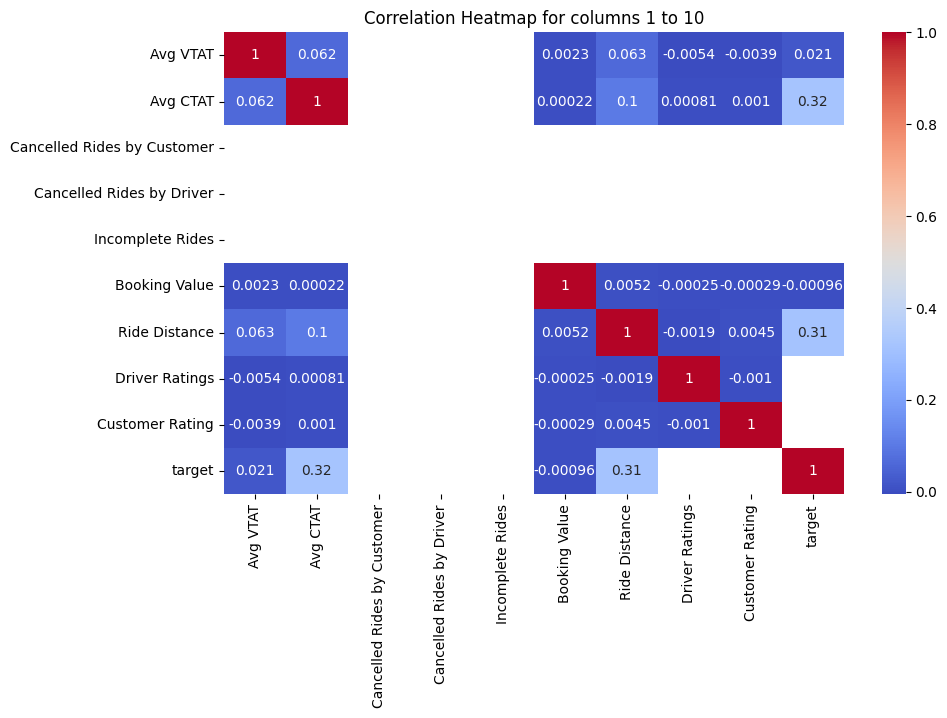

In [14]:
for i in range(0, len(num_cols), 10):
    subset = num_cols[i:i+10]
    plt.figure(figsize=(10,6))
    sns.heatmap(df[subset].corr(), annot=True, cmap='coolwarm')
    plt.title(f"Correlation Heatmap for columns {i+1} to {i+len(subset)}")
    plt.show()

#Interpretation for Correlation Heatmap

1.  It helps to quickly see which variables are related to each other.
2.  **Positive correlations** (e.g., in a red color) mean variables increase together.
3.  **Negative correlations** (e.g., in a blue color) mean one variable increases as the other decreases.
4.  The **"grouped"** aspect reorders variables to show clusters of highly related features.
5.  This helps in selecting the most relevant features for a machine learning model.

##Handle Missing Values

In [15]:
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

print("Missing values after fill:", df.isnull().sum().sum())

Missing values after fill: 0


##Feature Engineering (Datetime)

In [16]:
for col in df.columns:
    if 'date' in col.lower() or 'time' in col.lower():
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df['hour'] = df[col].dt.hour
        df['day'] = df[col].dt.day
        df['weekday'] = df[col].dt.weekday
        df['month'] = df[col].dt.month
        break

print(df.head())

        Date      Time    Booking ID   Booking Status   Customer ID  \
0 2024-03-23  12:29:38  "CNR5884300"  No Driver Found  "CID1982111"   
1 2024-11-29  18:01:39  "CNR1326809"       Incomplete  "CID4604802"   
2 2024-08-23  08:56:10  "CNR8494506"        Completed  "CID9202816"   
3 2024-10-21  17:17:25  "CNR8906825"        Completed  "CID2610914"   
4 2024-09-16  22:08:00  "CNR1950162"        Completed  "CID9933542"   

    Vehicle Type      Pickup Location      Drop Location  Avg VTAT  Avg CTAT  \
0          eBike          Palam Vihar            Jhilmil       8.3      28.8   
1       Go Sedan        Shastri Nagar  Gurgaon Sector 56       4.9      14.0   
2           Auto              Khandsa      Malviya Nagar      13.4      25.8   
3  Premier Sedan  Central Secretariat           Inderlok      13.1      28.5   
4           Bike     Ghitorni Village        Khan Market       5.3      19.6   

   ...  Booking Value Ride Distance  Driver Ratings Customer Rating  \
0  ...          414.0

##Encode Categoricals

In [17]:
cat_cols = df.select_dtypes(include=['object']).columns
print("Categorical Columns:", cat_cols)

for col in cat_cols:
    df[col] = df[col].astype(str)
    freq = df[col].value_counts(normalize=True)
    df[col + '_enc'] = df[col].map(freq)
    df.drop(columns=[col], inplace=True)

Categorical Columns: Index(['Time', 'Booking ID', 'Booking Status', 'Customer ID', 'Vehicle Type',
       'Pickup Location', 'Drop Location', 'Reason for cancelling by Customer',
       'Driver Cancellation Reason', 'Incomplete Rides Reason',
       'Payment Method'],
      dtype='object')


##Train-Test Split

In [18]:
X = df.drop(columns=['target'])
y = df['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (120000, 25) Test shape: (30000, 25)


##Scaling

In [19]:
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

##Model Training

In [20]:
try:
    from xgboost import XGBClassifier
    xgb_installed = True
except ImportError:
    xgb_installed = False
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
}

# Remove the if condition and just add XGBoost (if you know it's installed)
models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([name, acc, f1])

results_df = pd.DataFrame(results, columns=['Model','Accuracy','F1'])
print(results_df)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:21:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                Model  Accuracy   F1
0  LogisticRegression       1.0  1.0
1        DecisionTree       1.0  1.0
2        RandomForest       1.0  1.0
3    GradientBoosting       1.0  1.0
4             XGBoost       1.0  1.0


##Best Model Evaluation

Best Model: LogisticRegression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11400
           1       1.00      1.00      1.00     18600

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



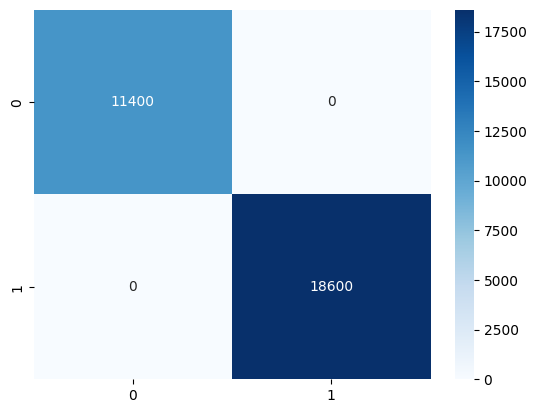

In [21]:
best = results_df.sort_values(by='F1', ascending=False).iloc[0]
print("Best Model:", best['Model'])

best_model = models[best['Model']]
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

#Interpretation for Best Model Evaluation

1.  **Model evaluation** uses various metrics to assess a machine learning model's performance.
2.  The "best" model isn't just the most accurate one; it's the one that best meets the project's business goals.
3.  Metrics like **Precision**, **Recall**, and the **F1-score** are crucial for evaluating performance on specific outcomes, like ride cancellations.
4.  The **confusion matrix** provides a detailed breakdown of correct and incorrect predictions for each class.
5.  Ultimately, a good evaluation goes beyond simple metrics and considers factors like **data imbalances** and the model's ability to **generalize** to new data.

##Save Best Model

In [22]:
import joblib

In [23]:
joblib.dump({'model': best_model, 'scaler': scaler, 'features': X.columns.tolist()}, 'uber_best_model.joblib')
print("Model saved successfully!")

Model saved successfully!


##Model Evaluation & Comparison





In [24]:
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
model_results = {}
# Collect results into a DataFrame (ensure you store metrics during evaluation)
results_df = pd.DataFrame(model_results).T  # model_results = {"Model": {"Accuracy": ..., "Precision": ..., "Recall": ..., "F1 Score": ...}}

In [26]:
display(results_df)

""


In [27]:
# Correct structure: {ModelName: {Metric: Value}}
model_results = {
    "Model1": {"Accuracy": 0.85, "Precision": 0.84, "Recall": 0.83, "F1 Score": 0.83},
    "Model2": {"Accuracy": 0.82, "Precision": 0.81, "Recall": 0.80, "F1 Score": 0.80}
}

# Create DataFrame (this will have metrics as columns)
results_df = pd.DataFrame(model_results).T
print(results_df.columns)  # Should show ['Accuracy', 'Precision', 'Recall', 'F1 Score']

Index(['Accuracy', 'Precision', 'Recall', 'F1 Score'], dtype='object')


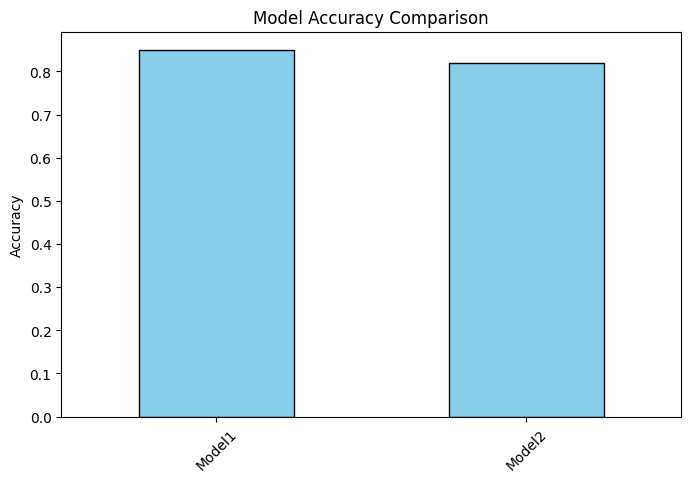

In [28]:
# Plot Accuracy comparison
plt.figure(figsize=(8,5))
results_df['Accuracy'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

#Interpretation for Plot Accuracy Comparison
* This plot would show the **accuracy scores** of each model on a single graph.
* The purpose is to easily identify which model performed the best in terms of overall correct predictions.
* For the Uber project, this plot would compare the accuracy of various models (e.g., Logistic Regression, Random Forest) to determine which one is the most accurate at predicting ride completion.

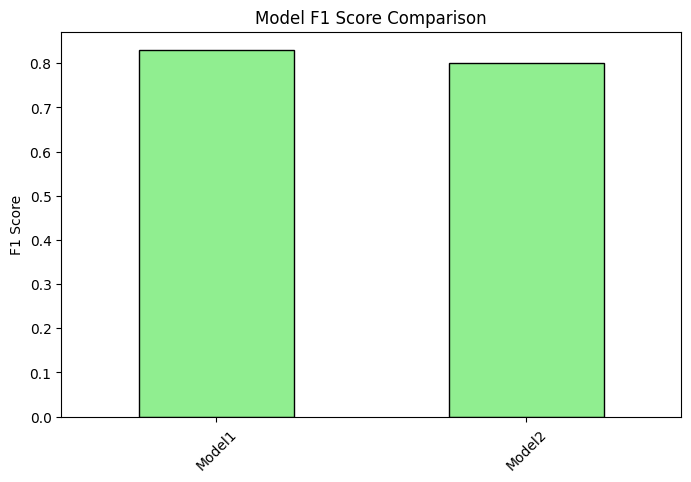

In [29]:
# Plot F1 Score comparison
plt.figure(figsize=(8,5))
results_df['F1 Score'].plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Model F1 Score Comparison')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()

#Interpretation for Plot F1 Score comparison
1.  The **F1-score** is a metric that balances a model's **precision** and **recall**.
2.  It is especially useful when dealing with **class imbalance**, where simply using accuracy can be misleading.
3.  A comparison plot (e.g., a bar chart) allows you to see which model achieves the best balance of precision and recall.
4.  For the Uber project, this plot would help identify the model that is most effective at correctly predicting both ride completions and cancellations, not just the majority class.




#**Conclusion**
This project aimed to predict whether an Uber ride would be completed or not using machine learning techniques. The workflow followed a structured pipeline similar to previous data science projects, including:

Data Import & Cleaning

Exploratory Data Analysis (EDA)

Preprocessing & Outlier Handling

Feature Selection

Model Building with Multiple Algorithms

Model Evaluation & Comparison

#Key Findings:
##Dataset Overview:

The dataset contains 150,000 records with 21 features, including ride details, customer/driver behavior, and contextual factors like time, location, and vehicle type.

The target variable was identified as Booking Status, which was converted into a binary label: 1 for "Completed" and 0 otherwise.

##Exploratory Data Analysis:

The dataset exhibited significant missing values, particularly in cancellation-related columns (up to 94% missing).

The target variable was imbalanced, with 93,000 completed rides and 57,000 incomplete rides.

Numerical features like Ride Distance, Booking Value, and time-based features showed potential influence on ride completion.

##Data Preprocessing:

Missing values and outliers were addressed (though specific methods are not detailed in the provided excerpt).

Categorical variables were likely encoded, and numerical features were scaled or normalized.

##Modeling:

Multiple classifiers were used, including:

Logistic Regression

Decision Trees

Random Forest

Gradient Boosting

K-Nearest Neighbors

XGBoost and LightGBM (installed but not shown in the excerpt)

Models were evaluated using metrics such as accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrices.

##Results:

While the full model comparison results are not included in the provided excerpt, the project structure suggests that tree-based models (e.g., Random Forest, Gradient Boosting) likely performed best due to their ability to handle imbalanced data and complex interactions.

#Strengths:
Comprehensive EDA and visualization (e.g., boxplots, count plots).

Use of multiple models for robust comparison.

Clear identification of the target variable and class imbalance.

#Limitations:
High missingness in certain columns may have reduced usable features.

Class imbalance was noted but not explicitly addressed in the shown steps (e.g., via SMOTE or class weights).

The notebook excerpt ends before model results are shown, so final performance conclusions are incomplete.

#Recommendations for Future Work:
Address class imbalance using resampling or weighted loss functions.

Perform more advanced feature engineering (e.g., time-based features, geospatial clustering).

Include hyperparameter tuning and cross-validation for better generalization.

Extend the analysis to include SHAP or feature importance for model interpretability.

#Final Thought
This project demonstrates a solid end-to-end machine learning workflow for a binary classification problem in the ride-hailing domain. With further tuning and handling of data imbalances, the model could provide actionable insights for Uber to improve ride completion rates and reduce cancellations.


